In [7]:
cd ..

/Users/SP/code/spectralCV


In [8]:
%matplotlib inline

# imports
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os

import neurodsp as ndsp
from scv_funcs import lfpca
from scv_funcs import utils

CKEYS = plt.rcParams['axes.prop_cycle'].by_key()['color']
font = {'family' : 'arial',
        'weight' : 'regular',
        'size'   : 15}
import matplotlib
matplotlib.rc('font', **font)

In [9]:
# from bokeh.plotting import figure, output_file, save
# output_file("kjm_bp.html")

In [10]:
# electrode location
elec_def = {
    '1': 'dorsal M1',
    '3': 'dorsal S1',
    '4': 'ventral S1+M1',
    '6': 'frontal (non-R)',
    '7': 'parietal (non-R)',
    '8': 'temporal',
    '9': 'occipital'
}
fs = 1000.

In [11]:
from ipywidgets import interact
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from scipy.stats import expon
output_notebook()

Loading BokehJS ...

In [12]:
cd results/kjm_digits/bp/

/Users/SP/code/spectralCV/results/kjm_digits/bp


In [13]:
trial_data = np.load('trial_info.npz')

In [14]:
trial_info = trial_data['trial_info']
elec_regions = trial_data['elec_regions']

In [15]:
lfpca_all = []
lfpca_all.append(lfpca.lfpca_load_spec('pre.npz'))
lf = lfpca_all[0]

In [16]:
chan_sel = []
for plot_chan in range(lf.numchan):
    try:
        ele_name = elec_def[elec_regions[plot_chan].astype(str)]
    except:
        ele_name = 'others'
    chan_sel.append('%i: '%plot_chan+ele_name)
    
def update_spct_hist(x, y, f=10, channel=0, numbins=20):
    plot_chan = int(channel.split(':')[0])
    plot_freq = np.where(lf.f_axis==f)[0][0]
    y, x = np.histogram(lf.spg[plot_chan,plot_freq,:], bins=numbins, density=True)
    # update histogram with data from frequency f
    hist_plot.data_source.data['left'] = x[:-1]
    hist_plot.data_source.data['right'] = x[1:]
    hist_plot.data_source.data['top'] = y    
    # update fitted
    rv = expon(scale=sp.stats.expon.fit(lf.spg[plot_chan,plot_freq,:],floc=0)[1])
    fit_plot.data_source.data['x'] = x
    fit_plot.data_source.data['y'] = rv.pdf(x)
    
    hist_fig.title.text = elec_def[elec_regions[plot_chan].astype(str)] + ': f=%.1fHz, p=%.4f '%(f,lf.ks_pvals[plot_chan,plot_freq])
    push_notebook()

In [11]:
y, x = np.histogram(lf.spg[0,10,:], bins=20, density=True)
hist_fig = figure(plot_height=400, plot_width=400, x_axis_label='Power', y_axis_label='Probability',background_fill_color="#E8DDCB")
hist_plot = hist_fig.quad(top=y, bottom=0, left=x[:-1], right=x[1:], fill_color="#036564", line_color="#033649")
fit_plot = hist_fig.line(x[:-1],y, line_width=8,alpha=0.7,line_color="#D95B43",legend='Fit PDF')
show(hist_fig, notebook_handle=True)
interact(update_spct_hist, x=x, y=y, f=(1,100), numbins=(10,55,5), channel=chan_sel)

ValueError: array([  1.59922163e+02,   2.25284670e+04,   4.48970118e+04,
         6.72655567e+04,   8.96341015e+04,   1.12002646e+05,
         1.34371191e+05,   1.56739736e+05,   1.79108281e+05,
         2.01476826e+05,   2.23845370e+05,   2.46213915e+05,
         2.68582460e+05,   2.90951005e+05,   3.13319550e+05,
         3.35688095e+05,   3.58056639e+05,   3.80425184e+05,
         4.02793729e+05,   4.25162274e+05,   4.47530819e+05]) cannot be transformed to a Widget

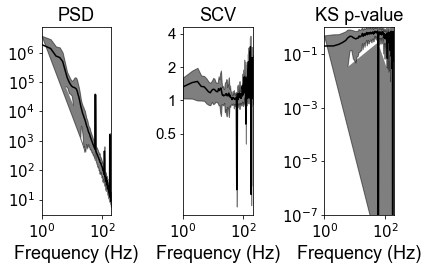

In [12]:
lf.plot_spectral()

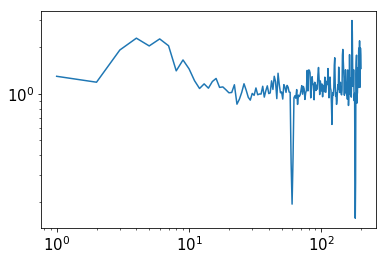

In [13]:
plt.loglog(lf.f_axis,lf.scv[0].T)

/Users/SP/anaconda/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


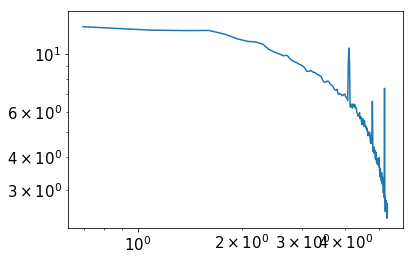

In [14]:
# plotting psd
plt.loglog(np.log(lf.f_axis),np.log(lf.psd[0].T))

In [15]:
lf.f_axis[1:]

array([   1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,    9.,
         10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,   18.,
         19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,   27.,
         28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,   36.,
         37.,   38.,   39.,   40.,   41.,   42.,   43.,   44.,   45.,
         46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,   54.,
         55.,   56.,   57.,   58.,   59.,   60.,   61.,   62.,   63.,
         64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,   72.,
         73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,   81.,
         82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,   90.,
         91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,   99.,
        100.,  101.,  102.,  103.,  104.,  105.,  106.,  107.,  108.,
        109.,  110.,  111.,  112.,  113.,  114.,  115.,  116.,  117.,
        118.,  119.,  120.,  121.,  122.,  123.,  124.,  125.,  126.,
        127.,  128.,

In [31]:
from bokeh.io import output_file, show
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.models.widgets import PreText, Select, Slider
from bokeh.io import curdoc
from bokeh.layouts import row, column
from bokeh.models import Span

chan_count, freq = lf.psd.shape

DEFAULT_TICKERS = list(map(str, range(chan_count)))
ticker = Select(value='0', title='channel', options=DEFAULT_TICKERS)

x = np.log(lf.f_axis[1:])
y0 = np.log(lf.psd[1].T[1:])
y1 = np.log(lf.scv[1].T[1:])

# create a column data source for the plots to share
source = ColumnDataSource(data=dict(x=x, y0=y0, y1=y1))

TOOLS = "box_select,lasso_select,help"

left = figure(tools=TOOLS, plot_width=300, plot_height=300, title='PSD')
right = figure(tools=TOOLS, plot_width=300, plot_height=300, title='SCV')

freq = np.log(50)

def left_psd_plot(source, freq):
    # create a new plot and add a renderer
    left.line('x', 'y0', source=source, color='navy')
    left.circle('x', 'y0', source=source, size=4, color='darkgrey', alpha=0.2)
    left.legend.location = 'top_left'
    left.xaxis.axis_label = 'Frequency (Hz)'
    left.yaxis.axis_label = 'Power/Frequency (dB/Hz)'
    left.grid.grid_line_alpha=0.3
    vline = Span(location=freq, dimension='height', line_color='red', line_width=3)
    left.renderers.extend([vline])
    
def right_scv_plot(source, freq):
    # create another new plot and add a renderer
    right.line('x', 'y1', source=source, color='navy')
    right.circle('x', 'y1', source=source, size=4, color='darkgrey', alpha=0.2)
    right.legend.location='top_left'
    right.xaxis.axis_label = 'Frequency (Hz)'
    right.yaxis.axis_label = 'Unitless'
    right.grid.grid_line_alpha=0.3
    vline = Span(location=freq, dimension='height', line_color='red', line_width=3)
    right.renderers.extend([vline])

def selection_change(attr, old, new):
    left = left
    right = right
    chan = int(ticker.value)
    x = np.log(lf.f_axis[1:])
    y0 = np.log(lf.psd[chan].T[1:])
    y1 = np.log(lf.scv[chan].T[1:])
    data = dict(x=x, y0=y0, y1=y1)
    # create a column data source for the plots to share
    source.data = data
    left_psd_plot(source=data, freq=freq)
    right_scv_plot(source=data, freq=freq)

left_psd_plot(source, freq)
right_scv_plot(source,freq)
p = gridplot([[left, right]], plot_width=400, plot_height=400)

ticker.on_change('value', selection_change)

slider = Slider(start=0, end=200, value=50, step=1, title="Frequency")

def slider_callback(attr, old, new):
    N = new  # this works also with slider.value but new is more explicit
    new_freq = np.log(N)
    left_psd_plot(source=source,freq=new_freq)
    right_psd_plot(source=source,freq=new_freq)

slider.on_change('value', slider_callback)
    
widgets = row(ticker, slider)
main_row = row(widgets)
layout = column(main_row, p)

# show(widgetbox(select))
curdoc().add_root(layout)

show(layout)

In [ ]:
int('44')

In [ ]:
interact(update_spct_hist, f=(1,100), numbins=(10,55,5), channel=chan_sel)

In [ ]:
type(range(10,15))

Loading BokehJS ...

In [4]:
from bokeh.io import show, output_notebook
from bokeh.models import HoverTool, NumeralTickFormatter, SingleIntervalTicker, LinearAxis, ColumnDataSource
from bokeh.plotting import figure
from bokeh.sampledata.us_marriages_divorces import data
output_notebook()

md_data = data.copy()

# Fill in missing data with a simple linear interpolation
md_data = md_data.interpolate(method='linear', axis=0).ffill().bfill()

# Set up the data sources for the lines we'll be plotting.
# We need separate data sources for each line because we're
# displaying different data in the hover tool.

source_marriages = ColumnDataSource(
    data=dict(
        # x-axis (Years) for the chart
        x=md_data.Year.values,
        # y-axis (Marriages per capita) for the chart
        y=md_data.Marriages_per_1000.values,
        # The string version of the y-value that is displayed in the hover box
        y_text=md_data.Marriages_per_1000.apply(lambda x: '{}'.format(round(x, 1))),
        # Extra descriptive text that is displayed in the hover box
        desc=['marriages per 1,000 people'] * len(md_data),
    )
)

source_divorces = ColumnDataSource(
    data=dict(
        # x-axis (Years) for the chart
        x=md_data.Year.values,
        # y-axis (Marriages per capita) for the chart
        y=md_data.Divorces_per_1000.values,
        # The string version of the y-value that is displayed in the hover box
        y_text=md_data.Divorces_per_1000.apply(lambda x: '{}'.format(round(x, 1))),
        # Extra descriptive text that is displayed in the hover box
        desc=['divorces and annulments per 1,000 people'] * len(md_data),
    )
)

# Use HTML to mark up the tooltip that displays over the chart
# Note that the variables in the data sources (above) are referenced with a @
hover = HoverTool(tooltips='<font face="Arial" size="3">@y_text @desc in @x</font>', mode='vline')

# Select the tools that will be available to the chart
TOOLS = ['pan,wheel_zoom,box_zoom,reset,save'] + [hover]

bplot = figure(
    tools=TOOLS, plot_width=800, plot_height=400, x_axis_type=None, 
    title='144 years of marriage and divorce in the U.S.',
    responsive=True
)

# Create a custom x-axis with 10-year intervals
ticker = SingleIntervalTicker(interval=10, num_minor_ticks=0)
xaxis = LinearAxis(ticker=ticker)
bplot.add_layout(xaxis, 'below')

# Customize the y-axis
bplot.yaxis.formatter = NumeralTickFormatter(format='0.0a')
bplot.yaxis.axis_label = '# per 1,000 people'

# Finally, plot the data!
# Note that the data source determines what is plotted and what shows in the tooltips
bplot.line('x', 'y', color='#1f77b4', line_width=3, source=source_marriages)
bplot.line('x', 'y', color='#ff7f0e', line_width=3, source=source_divorces)

show(bplot)

Loading BokehJS ...

In [5]:
from __future__ import division

import numpy as np

from bokeh.models import ColumnDataSource, CustomJS, Rect
from bokeh.plotting import output_notebook, figure, show
from bokeh.layouts import row

output_notebook()

N = 20
img = np.empty((N,N), dtype=np.uint32)
view = img.view(dtype=np.uint8).reshape((N, N, 4))
for i in range(N):
    for j in range(N):
        view[i, j, 0] = int(i/N*255)
        view[i, j, 1] = 158
        view[i, j, 2] = int(j/N*255)
        view[i, j, 3] = 255
source = ColumnDataSource({'x':[], 'y':[], 'width':[], 'height':[]})
xrange_callback = CustomJS(args=dict(source=source), code="""
    var data = source.data;
    var start = cb_obj.start;
    var end = cb_obj.end;
    data['x'] = [start + (end - start) / 2];
    data['width'] = [end - start];
    source.change.emit();
""")

yrange_callback = CustomJS(args=dict(source=source), code="""
    var data = source.data;
    var start = cb_obj.start;
    var end = cb_obj.end;
    data['y'] = [start + (end - start) / 2];
    data['height'] = [end - start];
    source.change.emit();
""")
p1 = figure(title='Box Zoom Here', plot_width=400, plot_height=400,
            x_range=(0,10), y_range=(0,10), tools ='box_zoom,wheel_zoom,pan,reset')
p1.image_rgba(image=[img], x=[0], y=[0], dw=[10], dh=[10])
p1.x_range.callback = xrange_callback
p1.y_range.callback = yrange_callback

p2 = figure(title='See Zoom Window Here', plot_width=400, plot_height=400, 
            x_range=(0,10), y_range=(0,10), tools="")
p2.image_rgba(image=[img], x=[0], y=[0], dw=[10], dh=[10])
rect = Rect(x='x', y='y', width='width', height='height', fill_alpha=0, line_color='black')
p2.add_glyph(source, rect)
show(row(p1, p2))


Loading BokehJS ...